In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle

# Load the dataset
file_path = 'data_pp_lda_sentiment.csv'  
df = pd.read_csv(file_path)

# Convert to a format suitable for vectorization
df['review_cleaned'] = df['review_cleaned'].apply(lambda x: ' '.join(eval(x)))

# Define features and target
X = df['review_cleaned']  # Text data
y = df['sentiments']  # Target labels

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),  
    ('nb', MultinomialNB())                         
])

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Evaluate on the training data
y_train_pred = pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"\nTraining Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate on the testing data
y_test_pred = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

# Cross-validation scores
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean() * 100:.2f}%")

# Print classification report for test set
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

# Compute confusion matrix for test set
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=pipeline.named_steps['nb'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=pipeline.named_steps['nb'].classes_)

# Display the confusion matrix as a DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=pipeline.named_steps['nb'].classes_, columns=pipeline.named_steps['nb'].classes_)
print("\nConfusion Matrix (Test):")
print(conf_matrix_df)


# Save the pipeline model to a file
model_file = 'nb_model.pkl'
with open(model_file, 'wb') as file:
    pickle.dump(pipeline, file)
print(f"\nModel saved to {model_file}")



Training Accuracy: 78.46%
Testing Accuracy: 76.20%
Cross-Validation Accuracy Scores: [0.73438245 0.76633286 0.77122079 0.77023966 0.75342792]
Mean Cross-Validation Accuracy: 75.91%

Classification Report (Test):
              precision    recall  f1-score   support

          -1       0.72      0.63      0.67      1914
           0       0.96      0.22      0.36      1182
           1       0.77      0.93      0.84      5292

    accuracy                           0.76      8388
   macro avg       0.81      0.59      0.62      8388
weighted avg       0.78      0.76      0.73      8388


Confusion Matrix (Test):
      -1    0     1
-1  1206    4   704
 0   116  258   808
 1   357    7  4928

Model saved to nb_model.pkl


In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Define a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Define the parameter grid for tuning
param_grid = {
    'tfidf__max_features': [3000, 5000, 7000],  # Number of features to consider
    'tfidf__ngram_range': [(1, 1), (1, 2)],    # Use unigrams or unigrams + bigrams
    'tfidf__stop_words': [None, 'english'],    # Whether to remove stopwords
    'nb__alpha': [0.1, 0.5, 1.0]              # Smoothing parameter for Naive Bayes
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Metric to optimize
    verbose=3,
    n_jobs=-1  # Use all available cores
)

# Perform hyperparameter tuning
grid_search.fit(X_train, y_train)

# Best parameters and score
print("\nBest Parameters:")
print(grid_search.best_params_)
print(f"\nBest Cross-Validation Accuracy: {grid_search.best_score_ * 100:.2f}%")

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Set Accuracy with Best Model: {test_accuracy * 100:.2f}%")


Fitting 5 folds for each of 36 candidates, totalling 180 fits



Best Parameters:
{'nb__alpha': 0.1, 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english'}

Best Cross-Validation Accuracy: 80.64%

Test Set Accuracy with Best Model: 79.63%


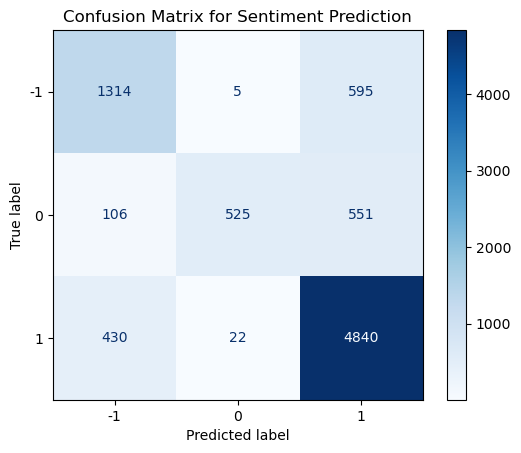

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions from the best model
y_test_pred = best_model.predict(X_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=best_model.named_steps['nb'].classes_)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.named_steps['nb'].classes_)
disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.title("Confusion Matrix for Sentiment Prediction")
plt.show()


In [7]:
from sklearn.metrics import classification_report

# Print the classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))



Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.71      0.69      0.70      1914
           0       0.95      0.44      0.61      1182
           1       0.81      0.91      0.86      5292

    accuracy                           0.80      8388
   macro avg       0.82      0.68      0.72      8388
weighted avg       0.81      0.80      0.79      8388



In [8]:
import pickle

# Save the best model to a file
model_file = 'best_nb_model.pkl'
with open(model_file, 'wb') as file:
    pickle.dump(best_model, file)

print(f"\nBest Model saved to {model_file}")



Best Model saved to best_nb_model.pkl


In [11]:
from textblob import TextBlob
import joblib

# Load the saved model
loaded_model = joblib.load("nb_model.pkl")

# Test with data reviews
new_reviews = [
    "Exactly what I was looking for! Shopped around quite a bit for a mid-level luxury car and the Q5 ultimately met all my desires.  A little bit more road noise on the highway than I was expecting but beyond that, the vehicle is awesome!  Luxurious while practical and looks pretty damn good out there on the road.",
    "Overrated Transmission shift from reverse to drive.",
    "The car has average features and is okay for its price",
    "Noisy car with problems, customer service sucks. The car makes a watch-like rapid ticking noise from day one, took the car to the dealership multiple times and were told it's the normal operation of the car. Car keeps pulling to the right, where the alignment can't fix, again dealership told me it's normal. Central locking intermittently beeps when locking the car. Worked with Audi customer service to resolve the issues. In the end, they basically told me to stay away, and every issue I had with the car is normal. My mistake to buy a car that manufacture doesn't stand behind their product. STAY FAR AWAY FROM AUDI..",
    "the car performs adequately for daily use , it has decent features and comfort but there are some areas for improvement such as fuel efficiency and interior space"
]

# Predict sentiments for the new reviews
new_predictions = loaded_model.predict(new_reviews)

# Display results with polarity
print("\nNew Reviews Predictions with Sentiment Polarity:")
for review, sentiment in zip(new_reviews, new_predictions):
    blob = TextBlob(review)
    polarity = blob.sentiment.polarity
    print(f"Review: \"{review}\"")
    print(f"=> Predicted Sentiment: {sentiment} | Polarity: {polarity:.2f}")
    print()



New Reviews Predictions with Sentiment Polarity:
Review: "Exactly what I was looking for! Shopped around quite a bit for a mid-level luxury car and the Q5 ultimately met all my desires.  A little bit more road noise on the highway than I was expecting but beyond that, the vehicle is awesome!  Luxurious while practical and looks pretty damn good out there on the road."
=> Predicted Sentiment: 1 | Polarity: 0.37

Review: "Overrated Transmission shift from reverse to drive."
=> Predicted Sentiment: 0 | Polarity: 0.00

Review: "The car has average features and is okay for its price"
=> Predicted Sentiment: 1 | Polarity: 0.17

Review: "Noisy car with problems, customer service sucks. The car makes a watch-like rapid ticking noise from day one, took the car to the dealership multiple times and were told it's the normal operation of the car. Car keeps pulling to the right, where the alignment can't fix, again dealership told me it's normal. Central locking intermittently beeps when locking t

In [8]:
import pandas as pd
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset
file_path = 'data_pp_lda_sentiment.csv'  # Update with the correct path
df = pd.read_csv(file_path)

# **Handle Missing Values**
df = df.dropna(subset=['review_cleaned', 'sentiments'])  # Remove NaN rows
df['review_cleaned'] = df['review_cleaned'].astype(str)  # Ensure text data is a string

# Define features and target
X = df['review_cleaned']  # Text data
y = df['sentiments']  # Target labels (Positive, Neutral, Negative)

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# **Convert text to numerical representation using TF-IDF**
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)  # Fit on training data
X_test_tfidf = tfidf.transform(X_test)  # Transform test data

# **Train Naïve Bayes Model**
nb_model = MultinomialNB(alpha=0.1)  # Laplace smoothing
nb_model.fit(X_train_tfidf, y_train)

# **Model Evaluation**
y_train_pred = nb_model.predict(X_train_tfidf)
y_test_pred = nb_model.predict(X_test_tfidf)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"\nTraining Accuracy: {train_acc * 100:.2f}%")
print(f"Testing Accuracy: {test_acc * 100:.2f}%")

# Classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

# **Display Confusion Matrix**
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=nb_model.classes_)
conf_df = pd.DataFrame(conf_matrix, index=nb_model.classes_, columns=nb_model.classes_)
print("\nConfusion Matrix (Test Set):")
print(conf_df)

# **Save Model and Vectorizer Using Pickle**
with open('nb_model.pkl', 'wb') as model_file:
    pickle.dump(nb_model, model_file)

with open('tfidf.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf, vectorizer_file)

print("\nModel and Vectorizer saved successfully using Pickle!")





Training Accuracy: 86.31%
Testing Accuracy: 85.55%

Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.75      0.68      0.71      1938
           0       1.00      0.82      0.90      1219
           1       0.86      0.92      0.89      5584

    accuracy                           0.86      8741
   macro avg       0.87      0.81      0.84      8741
weighted avg       0.86      0.86      0.85      8741


Confusion Matrix (Test Set):
      -1     0     1
-1  1318     0   620
 0    23  1001   195
 1   423     2  5159

Model and Vectorizer saved successfully using Pickle!


In [7]:
# **Load and Test Saved Model (Optional)**
with open('nb_model.pkl', 'rb') as model_file:
    loaded_nb_model = pickle.load(model_file)

with open('tfidf.pkl', 'rb') as vectorizer_file:
    loaded_tfidf = pickle.load(vectorizer_file)

# Test with a sample review
sample_text = ["Car is good but sometimes the engine is really bad"]
sample_tfidf = loaded_tfidf.transform(sample_text)
sample_pred = loaded_nb_model.predict(sample_tfidf)

print(f"\nSample Review Prediction: {sample_pred[0]}")


Sample Review Prediction: neutral
